In [21]:
import matplotlib.pyplot as plt
from smaller_model import UNET
import os
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

In [136]:
current_dir = os.getcwd()
project_dir = os.path.dirname(current_dir)
dataset_dir = os.path.join(project_dir, "Depth-Prediction/nyu_data/data/unused_data/bathroom_0030_out")

In [137]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_channels = 3

out_channels = 1

hidden_dims = [64, 128, 256, 512, 512]
model = UNET(input_channels, out_channels, hidden_dims).to(device)

In [138]:
model_path = os.path.join(project_dir, 'Depth-Prediction/Depth_Model.pth')
# print(model_path)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

UNET(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Seque

In [139]:
transform_rgb  = transforms.Compose([
    transforms.Resize((96, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [140]:
image_files = []
for filename in os.listdir(dataset_dir):
    # Check if the file is a JPG image
    if filename.endswith(".jpg"):
        rgb_path = os.path.join(dataset_dir, filename)
        # Construct the corresponding depth image path
        depth_filename = filename[:-4] + '.png'
        depth_path = os.path.join(dataset_dir, depth_filename)
        
        # Check if both RGB and depth images exist
        if os.path.exists(depth_path):
            image_files.append((rgb_path, depth_path))

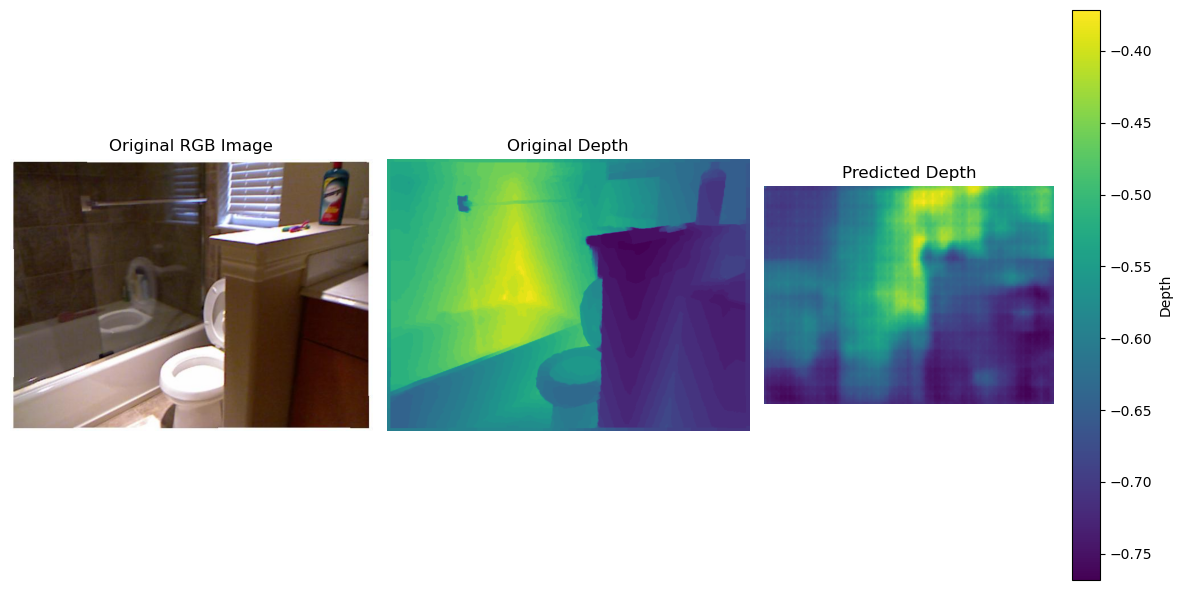

In [141]:
def visualize_rgb_and_depth(rgb_image, gray_image, depth_predicted):
    rgb_np = np.array(rgb_image)
    depth_np = depth_predicted.squeeze().cpu().detach().numpy()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
    ax1.imshow(rgb_np)
    ax1.set_title('Original RGB Image')
    ax1.axis('off')
    ax2.imshow(gray_image, cmap='viridis')
    ax2.set_title('Original Depth')
    ax2.axis('off')
    depth_plot = ax3.imshow(depth_np, cmap='viridis')
    ax3.set_title('Predicted Depth')
    ax3.axis('off')
    plt.colorbar(depth_plot, ax=ax3, label='Depth')
    
    plt.tight_layout()
    plt.show()

# Usage:
rgb_image = Image.open(image_files[6][0]).convert("RGB")
gray_image = Image.open(image_files[6][1]).convert("L")

# gray_image = Image.open(image)
depth_predicted = model(transform_rgb(rgb_image).unsqueeze(0).to(device))

visualize_rgb_and_depth(rgb_image, gray_image, depth_predicted)

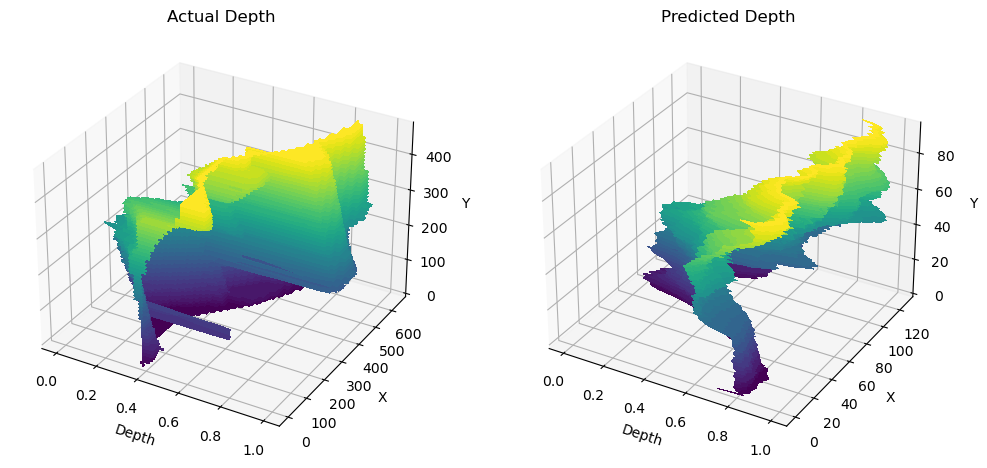

In [142]:
def graph_points_3d(
    original_depth,
    predicted_depth
):
    original_depth = np.array(original_depth)
    predicted_depth = predicted_depth.squeeze().cpu().detach().numpy()
    original_depth_normalized = 1 - (original_depth - original_depth.min()) / (original_depth.max() - original_depth.min())
    predicted_depth_normalized =  1 - (predicted_depth - predicted_depth.min()) / (predicted_depth.max() - predicted_depth.min())

    y, x = np.mgrid[0:original_depth_normalized.shape[0], 0:original_depth_normalized.shape[1]]    
    y1, x1 = np.mgrid[0:predicted_depth_normalized.shape[0], 0:predicted_depth_normalized.shape[1]]    
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(121, projection="3d")
    ax2 = fig.add_subplot(122, projection ="3d")
    surf = ax1.plot_surface(original_depth_normalized, x, y, cmap='viridis', linewidth=0, antialiased=False)
    surf2 = ax2.plot_surface(predicted_depth_normalized, x1, y1, cmap='viridis', linewidth=0, antialiased=False)

    # Customize the plot
    ax1.set_xlabel('Depth')
    ax1.set_ylabel('X')
    ax1.set_zlabel('Y')
    ax1.set_title("Actual Depth")

    ax2.set_xlabel('Depth')
    ax2.set_ylabel('X')
    ax2.set_zlabel('Y')
    ax2.set_title('Predicted Depth')
    # Show the plot
    plt.show()

graph_points_3d(gray_image, depth_predicted)